In [1]:
# from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

# wandb_run_id = init_wandb(run_name="price_match_simulation")
# print(f"Run ID {wandb_run_id}")

In [2]:
import pandas as pd
import pickle
import time

from ml_simulation.dataset_split import customer_split
from ml_simulation.util import HiddenPrints
from ml_features.features import create_features
from ml_training.train_xgb import train_xgb
from ml_simulation.segment import get_nonconverted_customers

from ml_simulation__discount.shift import simulate_discount_conversion_shift
from ml_simulation__price.shift import simulate_price_conversion_shift
from ml_simulation__budget.shift import simulate_budget_conversion_shift
from ml_simulation__cross_sell.shift import simulate_cross_sell_conversion_shift
from ml_simulation__follow_up.shift import simulate_follow_up_conversion_shift
from ml_simulation__sales_rep.shift import simulate_sales_rep_conversion_shift
    
import warnings
warnings.filterwarnings('ignore')

df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

In [3]:
split_result = customer_split(df_quotes)
df_train = split_result['train']
df_sim = get_nonconverted_customers(split_result['simulation'])


SPLIT CUSTOMERS: TRAIN vs SIMULATION: TRAINING SIZE 0.95
Split: 22708 train, 1180 sim customers
Non-converted customers: 923


In [4]:
TRAIN = False

In [5]:
# Model building
if TRAIN:
    with HiddenPrints():
        X_train = create_features(df_train)
    
    y_train = X_train['converted']
    X_train = X_train.drop(['numero_compte', 'converted'], axis=1)
    feature_names = X_train.columns.tolist()
    
    result = train_xgb(X_train, y_train, "simulation_poc")
    model = result['model']
    feature_names = result['features']
    
    print(f"Model trained: {len(feature_names)} features")
else:
    with open('simulation_poc.pkl', 'rb') as file:
        model_data = pickle.load(file)
        model = model_data['model']
        feature_names = model_data['features']

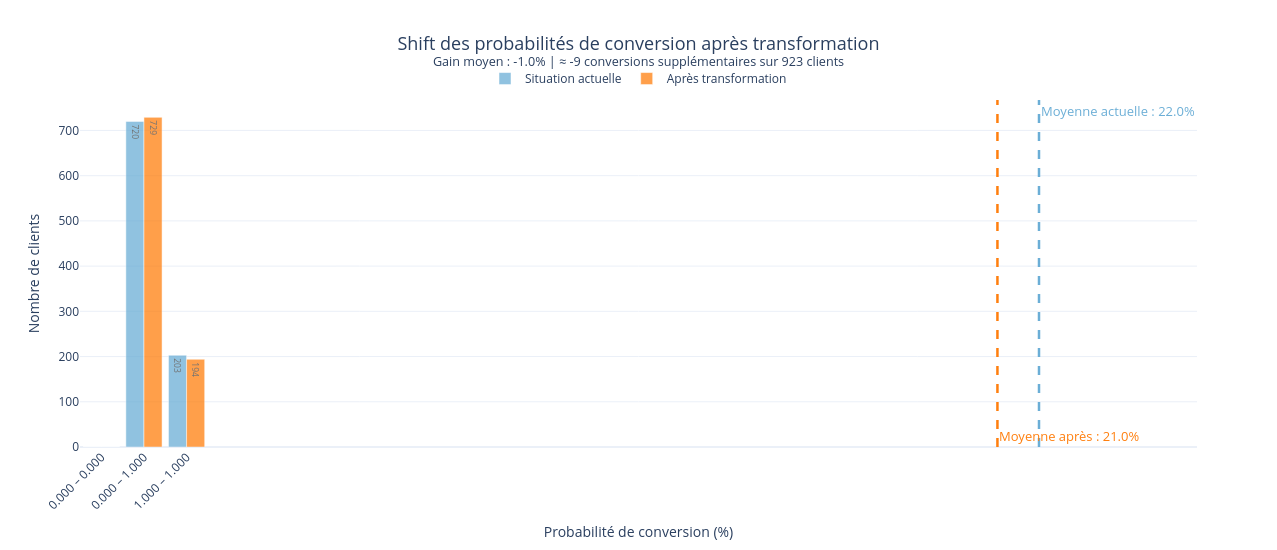

In [13]:
comparison_df = simulate_discount_conversion_shift(df_sim, model, 1.5)

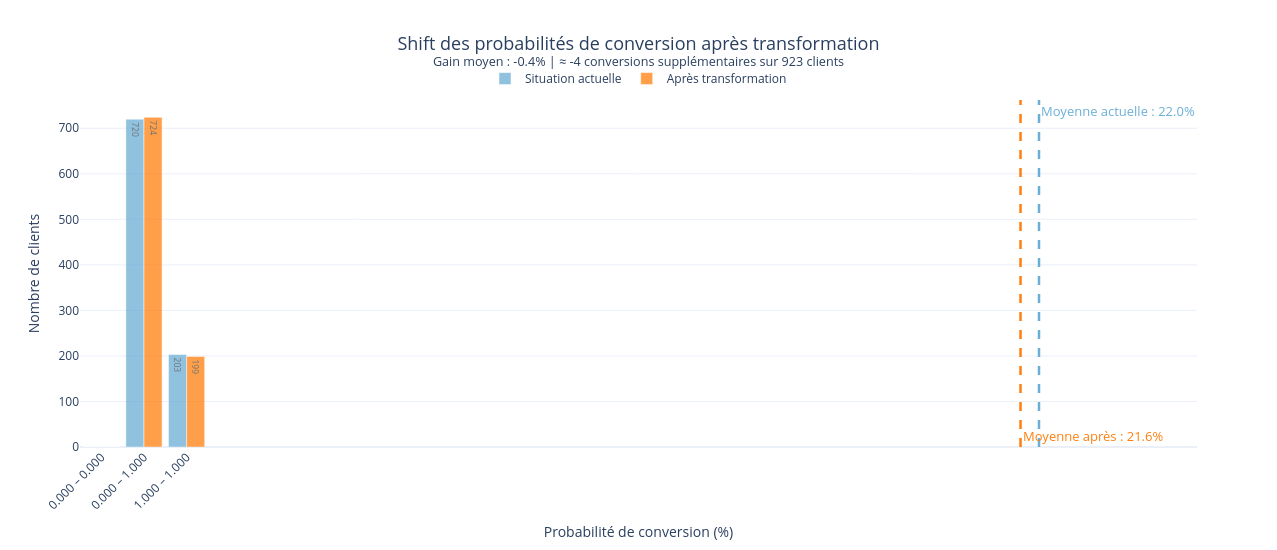

In [14]:
comparison_df = simulate_price_conversion_shift(df_sim, model, 0.2)

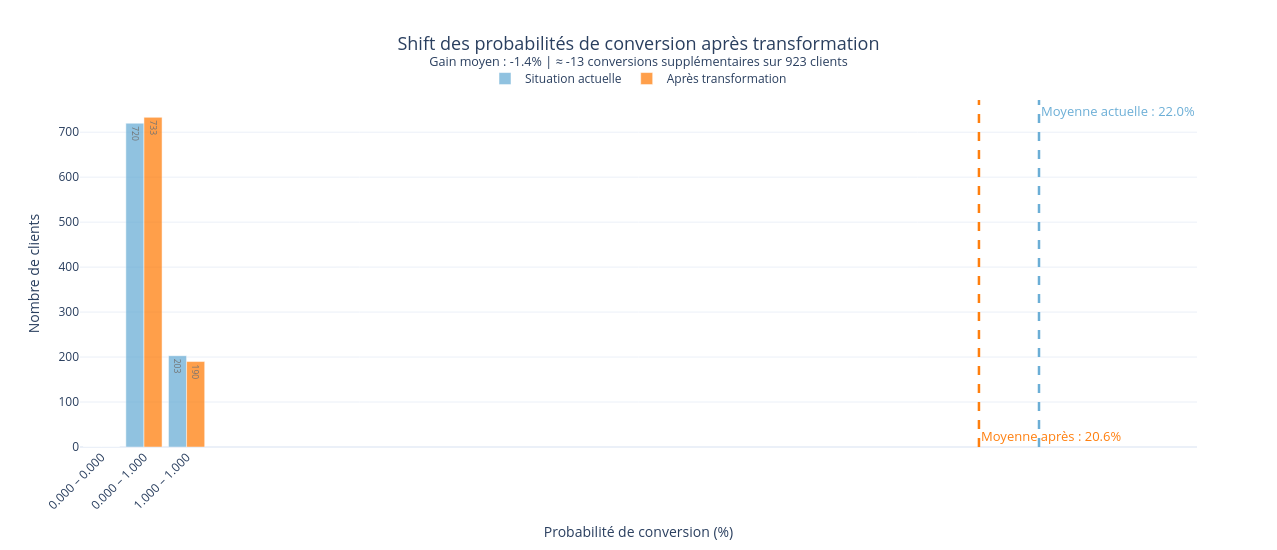

In [8]:
comparison_df = simulate_budget_conversion_shift(df_sim, model)

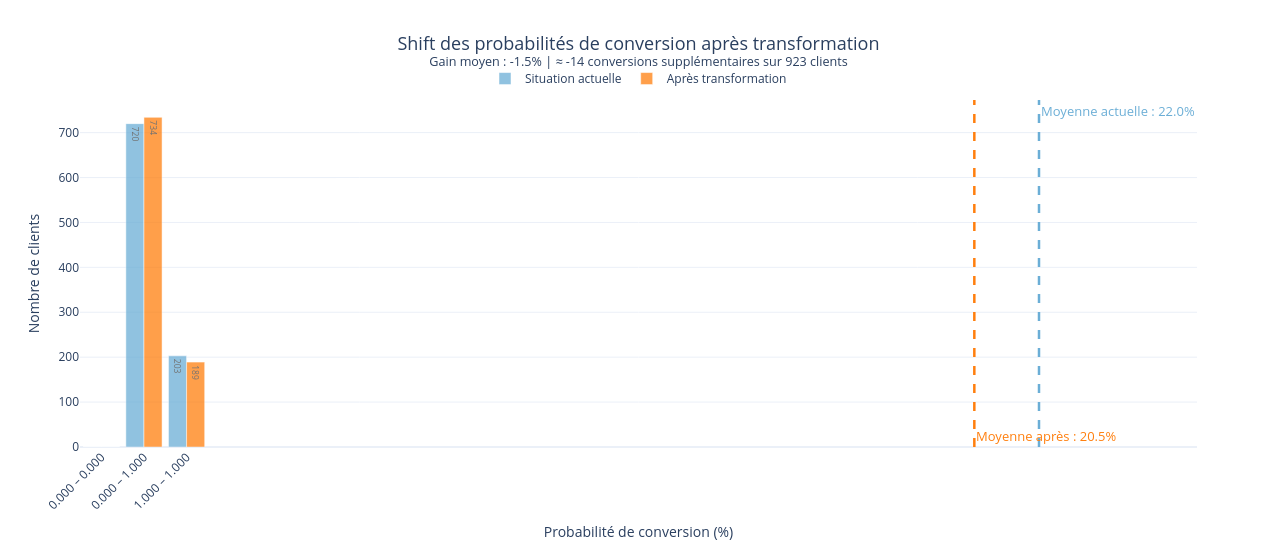

In [9]:
comparison_df = simulate_cross_sell_conversion_shift(df_sim, model)

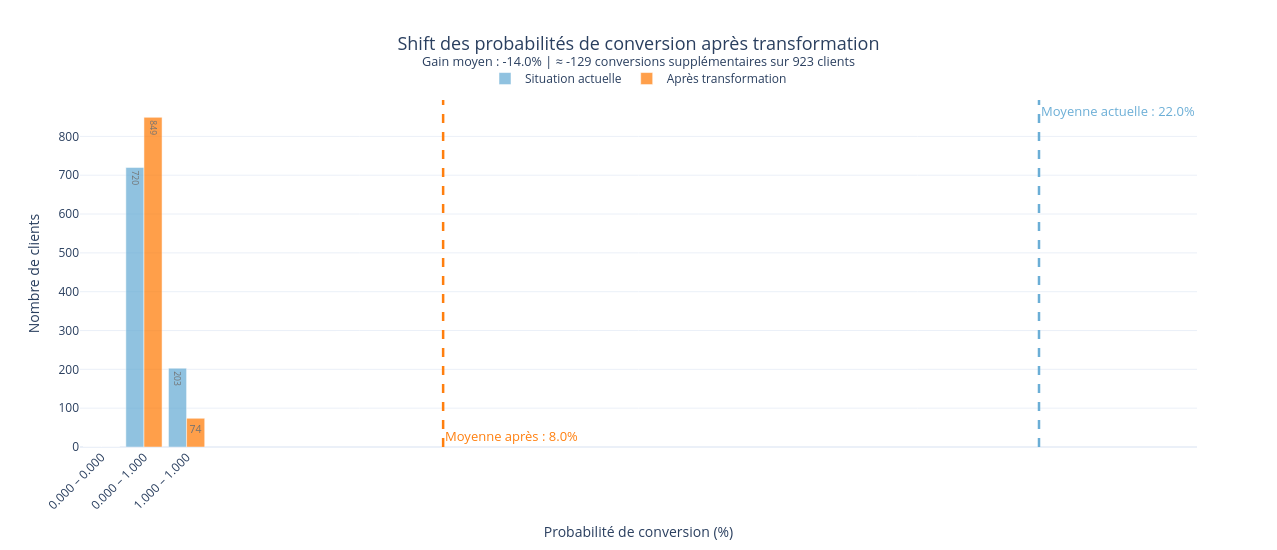

In [10]:
comparison_df = simulate_follow_up_conversion_shift(df_sim, model)

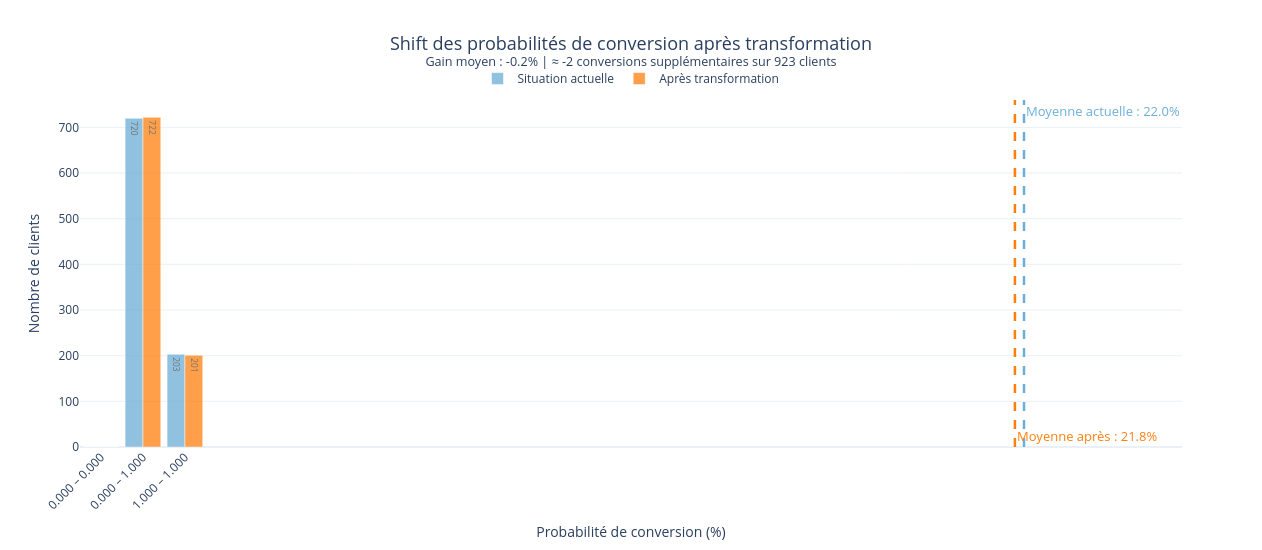

In [11]:
comparison_df = simulate_sales_rep_conversion_shift(df_sim, model)

In [12]:
print("Number of customers:", len(comparison_df))

print("\nBase prediction stats:")
print(comparison_df['base_prediction'].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print("Transformed prediction stats:")
print(comparison_df['new_prediction'].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# How many are very low or very high?
print("\nFraction near 0 or 1 (base):")
print((comparison_df['base_prediction'] <= 0.05).mean())
print((comparison_df['base_prediction'] >= 0.95).mean())

print("\nFraction near 0 or 1 (transformed):")
print((comparison_df['new_prediction'] <= 0.05).mean())
print((comparison_df['new_prediction'] >= 0.95).mean())

# Check for NaN / invalid values
print("\nAny NaN in predictions?", comparison_df[['base_prediction', 'new_prediction']].isna().any().any())

Number of customers: 923

Base prediction stats:
count    923.000000
mean       0.219935
std        0.414427
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
90%        1.000000
95%        1.000000
99%        1.000000
max        1.000000
Name: base_prediction, dtype: float64
Transformed prediction stats:
count    923.000000
mean       0.217768
std        0.412953
min        0.000000
1%         0.000000
5%         0.000000
10%        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
90%        1.000000
95%        1.000000
99%        1.000000
max        1.000000
Name: new_prediction, dtype: float64

Fraction near 0 or 1 (base):
0.7800650054171181
0.2199349945828819

Fraction near 0 or 1 (transformed):
0.7822318526543879
0.21776814734561215

Any NaN in predictions? False
